In [ ]:
!pip install xgboost lightgbm catboost shap

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap

In [3]:
# Set option to display all columns
pd.set_option("display.max_columns", None)

df = pd.read_csv(r"Part2-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Function to extract X and y
def prepare_dataset(df):

    # Remove unwanted column
    data = df.drop(columns=["customerID", "gender", "MultipleLines"]) # "MultipleLines", "StreamingTV", "StreamingMovies"

    # Change Objects to String
    categorical_features = data.select_dtypes("object").columns
    data[categorical_features] = data[categorical_features].astype("string")

    # Encode Target Variable
    data["Churn"] = data["Churn"].map({"Yes": 1, "No": 0})

    # Define X and y
    X = data.drop(columns=["Churn"])
    y = data["Churn"]

    return X, y

In [6]:
# Create X and y
X, y = prepare_dataset(df)

In [7]:
# Function to fix datatypes
def set_numerical_columns_datatype(X):
    X = X.copy()
    X["TotalCharges"] = pd.to_numeric(X["TotalCharges"], errors="coerce")
    X["MonthlyCharges"] = pd.to_numeric(X["MonthlyCharges"], errors="coerce")
    X["tenure"] = pd.to_numeric(X["tenure"], errors="coerce")
    return X

# Function to Fill NaNs
def impute_nans(X):
    X = X.copy()

    # Fix Tenure
    empty_tenure = X["tenure"].isna() & (~X["TotalCharges"].isna()) & (~X["MonthlyCharges"].isna())
    X.loc[empty_tenure, "tenure"] = (X.loc[empty_tenure, "TotalCharges"] - np.random.randint(5,31, size=empty_tenure.sum())) / X.loc[empty_tenure, "MonthlyCharges"]
    # Fallback
    X["tenure"] = X["tenure"].fillna(0)

    # Fix MonthlyCharges
    empty_monthly_charges = X["MonthlyCharges"].isna() & (~X["TotalCharges"].isna()) & (~X["tenure"].isna())
    X.loc[empty_monthly_charges, "MonthlyCharges"] = (X.loc[empty_monthly_charges, "TotalCharges"] - np.random.randint(5,31, size=empty_monthly_charges.sum())) / X.loc[empty_monthly_charges, "tenure"]
    # Fallback
    X["MonthlyCharges"] = X["MonthlyCharges"].fillna(0)

    # Fix TotalCharges
    empty_total_charges = X["TotalCharges"].isna()

    # Compute TotalCharges for Month-to-month
    mtm_total_charges = empty_total_charges & (X["Contract"] == "Month-to-month") & (X["tenure"] > 0)
    X.loc[mtm_total_charges, "TotalCharges"] = X.loc[mtm_total_charges, "MonthlyCharges"] * X.loc[mtm_total_charges, "tenure"] + np.random.randint(5,31, size=mtm_total_charges.sum())

    # Compute TotalCharges for One year
    one_year_charges = empty_total_charges & (X["Contract"] == "One year") & (X["tenure"] > 0)
    X.loc[one_year_charges, "TotalCharges"] = X.loc[one_year_charges, "tenure"]  * X.loc[one_year_charges, "MonthlyCharges"] + np.random.randint(5,31, size=one_year_charges.sum())

    # Compute TotalCharges for Two year
    two_year_charges = empty_total_charges & (X["Contract"] == "Two year") & (X["tenure"] > 0)
    X.loc[two_year_charges, "TotalCharges"] = X.loc[two_year_charges, "tenure"]  * X.loc[two_year_charges, "MonthlyCharges"] + np.random.randint(5,31, size=two_year_charges.sum())

    zero_tenure = empty_total_charges & (X["tenure"] == 0)
    X.loc[zero_tenure, "TotalCharges"] =  X.loc[zero_tenure, "MonthlyCharges"]

    return X

# Convert to Transformer object
nan_imputer = FunctionTransformer(
    impute_nans,
    validate=False
)

# Convert to Transformer object
type_coercion = FunctionTransformer(
    set_numerical_columns_datatype,
    validate=False
)

In [8]:
# Filter Numerical and Categorical columns names
numerical_columns = X.select_dtypes("number").columns
categorical_columns = X.columns.difference(numerical_columns)

# Define objects for Enncoding and Scaling
categorical_encoder = OneHotEncoder(sparse_output=False, dtype="int", handle_unknown="ignore")
numerical_scaler = StandardScaler()

# Combine into a ColumnTransformer
column_transformer  = ColumnTransformer(
    transformers=[
        ("scaler", numerical_scaler, numerical_columns),
        ("encoder", categorical_encoder, categorical_columns)
    ]
)

# Parse to Pipeline Instance
Preprocessing_Pipeline = Pipeline(steps=[
    ("type_fix", type_coercion),
    ("nan_fix", nan_imputer),
    ("x_features_transformer", column_transformer)
])

# Set Ouput to be DataFrame
Preprocessing_Pipeline.set_output(transform="pandas")

Pipeline(steps=[('type_fix',
                 FunctionTransformer(func=<function set_numerical_columns_datatype at 0x7d9bb0c1e840>)),
                ('nan_fix',
                 FunctionTransformer(func=<function impute_nans at 0x7d9bb0c1e8e0>)),
                ('x_features_transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('encoder',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Contract', 'Dependents', 'DeviceProtection', 'InternetService',
       'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling', 'Partner',
       'PaymentMethod', 'PhoneService', 'SeniorCitizen', 'StreamingMovies',
       'StreamingTV', 'TechSupport'],
      dtype='object'))]))])

### For Simple Ananlysis : Fit the pipeline on X and transform it
This allows us to carry out a little analysis on the entire transformed data before builidng a model with it's Training and Test Split

In [9]:
X_processed = Preprocessing_Pipeline.fit_transform(X)
X_processed.head()

,scaler__tenure,scaler__MonthlyCharges,scaler__TotalCharges,encoder__Contract_Month-to-month,encoder__Contract_One year,encoder__Contract_Two year,encoder__Dependents_No,encoder__Dependents_Yes,encoder__DeviceProtection_No,encoder__DeviceProtection_No internet service,encoder__DeviceProtection_Yes,encoder__InternetService_DSL,encoder__InternetService_Fiber optic,encoder__InternetService_No,encoder__OnlineBackup_No,encoder__OnlineBackup_No internet service,encoder__OnlineBackup_Yes,encoder__OnlineSecurity_No,encoder__OnlineSecurity_No internet service,encoder__OnlineSecurity_Yes,encoder__PaperlessBilling_No,encoder__PaperlessBilling_Yes,encoder__Partner_No,encoder__Partner_Yes,encoder__PaymentMethod_Bank transfer (automatic),encoder__PaymentMethod_Credit card (automatic),encoder__PaymentMethod_Electronic check,encoder__PaymentMethod_Mailed check,encoder__PhoneService_No,encoder__PhoneService_Yes,encoder__SeniorCitizen_No,encoder__SeniorCitizen_Yes,encoder__StreamingMovies_No,encoder__StreamingMovies_No internet service,encoder__StreamingMovies_Yes,encoder__StreamingTV_No,encoder__StreamingTV_No internet service,encoder__StreamingTV_Yes,encoder__TechSupport_No,encoder__TechSupport_No internet service,encoder__TechSupport_Yes
0,-1.277445,-1.160323,-0.992667,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0
1,0.066327,-0.259629,-0.172198,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0
2,-1.236724,-0.362660,-0.958122,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0
3,0.514251,-0.746535,-0.193706,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1
4,-1.236724,0.197365,-0.938930,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0


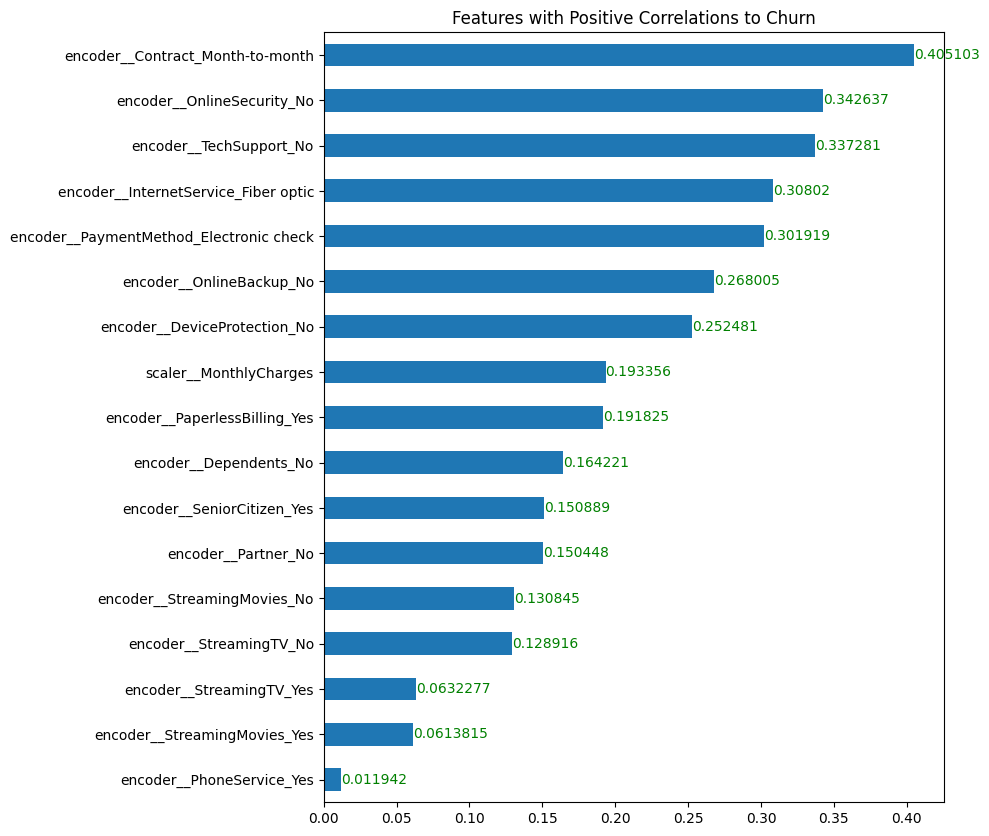

In [10]:
# Copy to dummy
dummy_encoded = X_processed.copy()
dummy_encoded["Churn"] = y

# Inspect Correlation
corr_matrix = dummy_encoded.corr()

# Visualise Positive Correlation values
corr_matrix["Churn"][corr_matrix["Churn"] > 0 ].sort_values().iloc[:-1].plot(kind="barh", figsize=(8, 10))
ax = plt.gca()
ax.bar_label(ax.containers[0], color="green")
ax.set_title("Features with Positive Correlations to Churn")
plt.show()

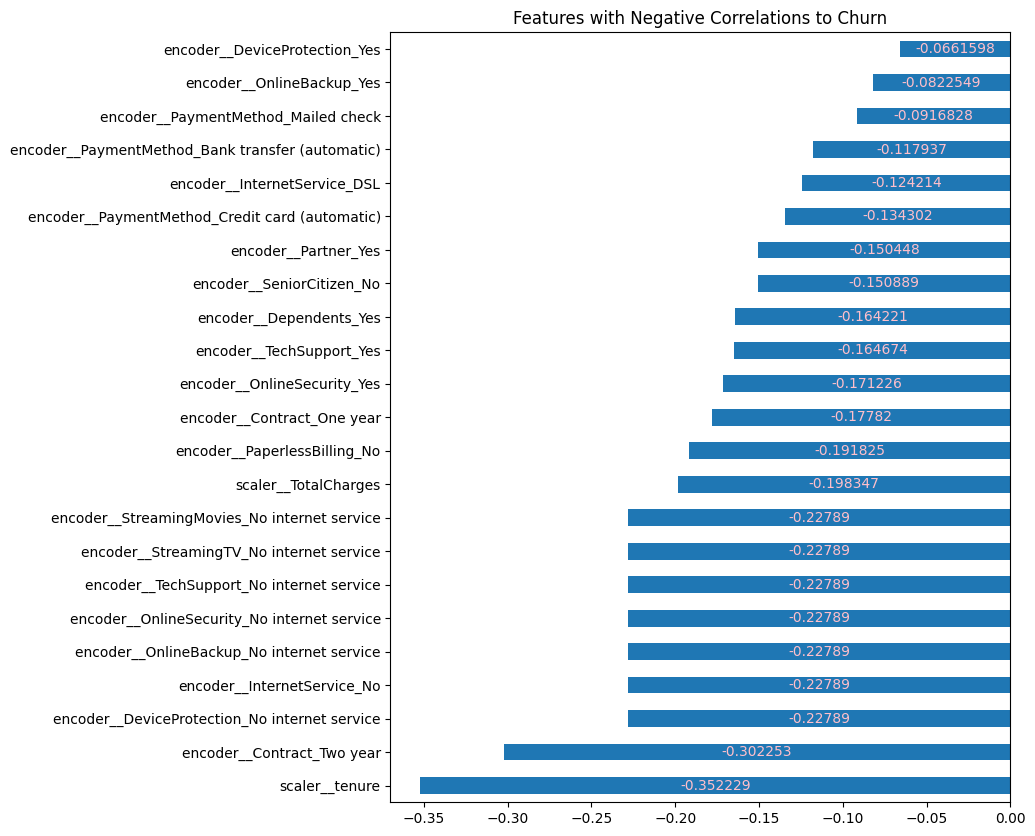

In [11]:
# Visualise Negative Correlation values
corr_matrix["Churn"][corr_matrix["Churn"] <= 0 ].sort_values().iloc[:-1].plot(kind="barh", figsize=(8, 10))
ax = plt.gca()
ax.bar_label(ax.containers[0], label_type="center", color="pink")
ax.set_title("Features with Negative Correlations to Churn")
plt.show()

Many of the features have little to no correlation effect with the Target variable.

### Time to Train the Models
- Split Data
- Define Model Pipelines

In [12]:
# Split to Train and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# For Logistic Regression
log_reg_pipe = Pipeline([
    ("prep", Preprocessing_Pipeline),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

# For Decision Tree
dec_tree_pipe = Pipeline([
    ("prep", Preprocessing_Pipeline),
    ("model", DecisionTreeClassifier(
        class_weight="balanced",
        random_state=42
    ))
])

# For Random Forest
random_forest_pipe = Pipeline([
    ("prep", Preprocessing_Pipeline),
    ("model", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# For Gradient Boost Pipeline
grad_boost_pipe = Pipeline([
    ("prep", Preprocessing_Pipeline),
    ("model", GradientBoostingClassifier(
        random_state=42
    ))
])

# For XGBoost Pipeline
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_pipe = Pipeline([
    ("prep", Preprocessing_Pipeline),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])

# For CatBoost Pipeline
cat_pipe = Pipeline([
    ("prep", Preprocessing_Pipeline),
    ("model", CatBoostClassifier(
        verbose=0,
        random_state=42
    ))
])


In [15]:
# Param Grid for Logistic Regression Model
log_reg_param = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__solver": ["saga"],
    "model__penalty": ["l1", "l2"],
    "model__class_weight": ["balanced", None],
    "model__max_iter": [2000]
}

# Param Grid for Decision Tree Model
dec_tree_param = {
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5]
}

# Param Grid for Random Forest Model
random_forest_param = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", "log2"]
}

# Param Grid for Gradient Boost Model
grad_boost_param = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 4],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 3],
    "model__subsample": [0.8, 1.0]
}

# Param Grid for XGBoost Model
xgb_param = {
    "model__n_estimators": [200, 400],
    "model__learning_rate": [0.03, 0.1],
    "model__max_depth": [3, 5],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__gamma": [0, 1],
    "model__scale_pos_weight": [scale_pos_weight]
}

# Param Grid for CatBoost Model
cat_param = {
    "model__iterations": [300, 500],
    "model__learning_rate": [0.03, 0.1],
    "model__depth": [4, 6],
    "model__l2_leaf_reg": [3, 7],
    "model__loss_function": ["Logloss"],
    "model__auto_class_weights": ["Balanced"]
}

In [16]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

grids = {
    "Logistic": (log_reg_pipe, log_reg_param),
    "DecisionTree": (dec_tree_pipe, dec_tree_param),
    "RandomForest": (random_forest_pipe, random_forest_param),
    "GradientBoosting": (grad_boost_pipe, grad_boost_param),
    "XGBoost": (xgb_pipe, xgb_param),
    "CatBoost": (cat_pipe, cat_param)
}

best_models = {}

for name, (pipe, params) in grids.items():
    gs = GridSearchCV(
        pipe,
        params,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1
    )
    gs.fit(X_train, y_train)

    best_models[name] = gs.best_estimator_
    print(f"{name} ROC-AUC: {gs.best_score_:.4f}")

Logistic ROC-AUC: 0.8461
DecisionTree ROC-AUC: 0.8295
RandomForest ROC-AUC: 0.8439
GradientBoosting ROC-AUC: 0.8495


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:19:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost ROC-AUC: 0.8491
CatBoost ROC-AUC: 0.8491


The best performing Model is the
- **Gradient Boost Model**
> It has the best score of all the models.

We will be using 0.3 as our custom threshold as it shows better classifications report at that value.

In [17]:
# Make probabilitic predictions and extract values for the positive class
y_probs = best_models["GradientBoosting"].predict_proba(X_test)[:, 1]

# Set the custom threshold
threshold = 0.3
# Set values as numbers
y_pred = (y_probs >= threshold).astype(int)

# Print the Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (threshold=0.3):")
print(cm)

# Print the Classification Report
print("\nClassification Report (threshold=0.3):")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix (threshold=0.3):
[[796 239]
 [ 86 288]]

Classification Report (threshold=0.3):
              precision    recall  f1-score   support

           0     0.9025    0.7691    0.8305      1035
           1     0.5465    0.7701    0.6393       374

    accuracy                         0.7693      1409
   macro avg     0.7245    0.7696    0.7349      1409
weighted avg     0.8080    0.7693    0.7797      1409



This model and threshold has the following metrics:
- **TN (True Negatives)** = `796`: Non-churners correctly predicted as Non-churners ✅.
- **FP (False Positives)** = `239`: Non-churners incorrectly predicted as churners ❌.
> These are **Extra churn alerts** and could increase communication cost if the customers are contacted.
- **FN (False Negatives)** = `86`: Churners incorrectly predicted as Non-churners. This aspect is most critical, since these are missed Churners ❌.
- **TP (True Positives)** = `288`: Churners correctly predicted and successfully targeted ✅.

<br>


<u>OVERVIEW:</u>
- The model above captures approximately `77%` of actual churners from the Test data, meaning the majority of churn events are successfully identified.

However, this comes at the cost of lower precision: since only about `55%` of customers predicted as churners actually churn. This  would result in a higher number of false positives (Non-churners incorrectly predicted as churners ❌), and increasing the cost of retention outreach.

This threshold reflects a deliberate trade-off favoring churner capture (recall) over precision, which would be appropriate when the cost of missing a churner is higher than the cost of contacting a non-churner.


Let's view more details about Churn Drivers learned by the model, using the plot below:

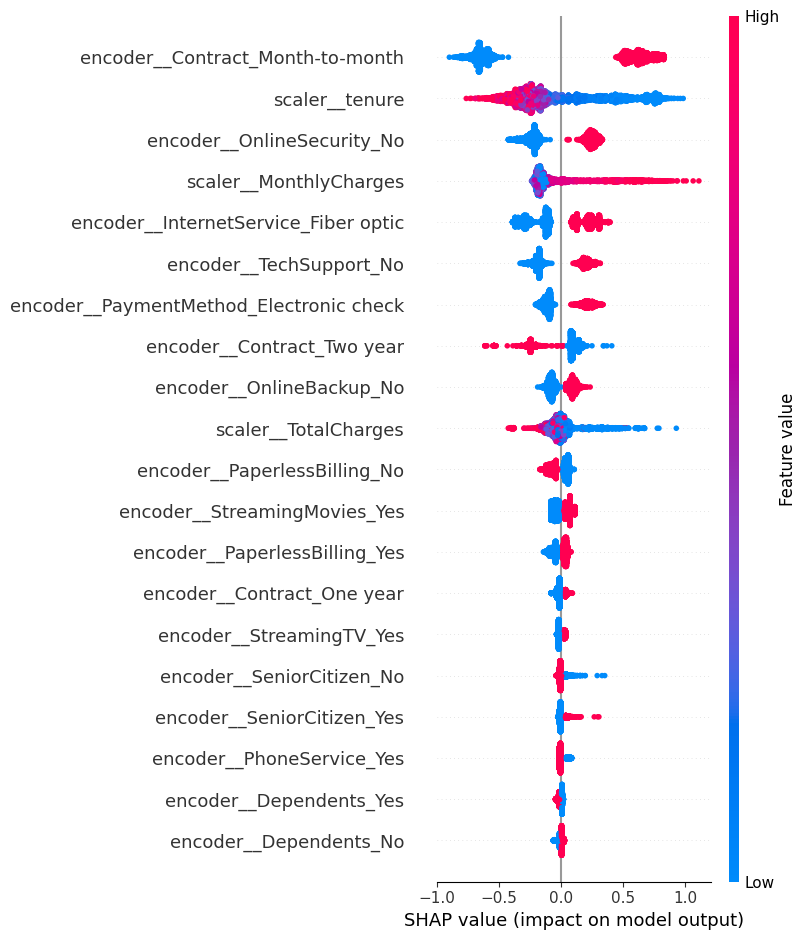

In [23]:
feature_names = column_transformer.get_feature_names_out()

gb_model = gb_pipeline.named_steps["model"]

explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names
)

From the plot above, the true top churn drivers are:
- Contract_Month-to-month
- Tenure
- OnlineSecurity_No
- MonthlyCharges
- InternetService_Fiber optic
- TechSupport_No
- PaymentMethod_Electronic check

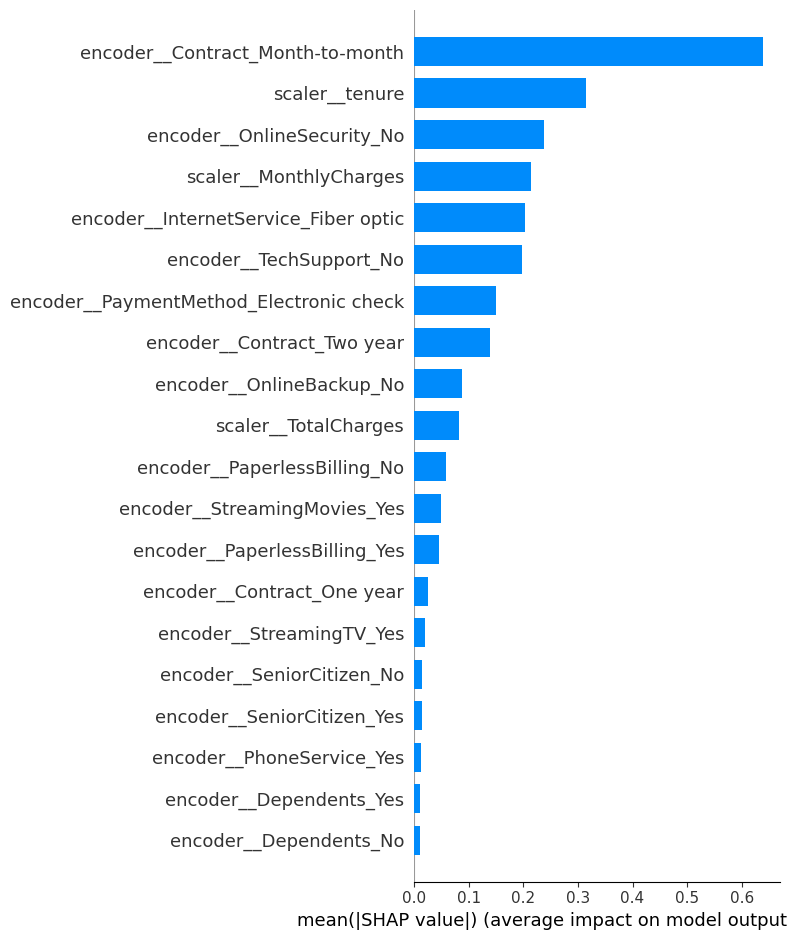

In [24]:
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    plot_type="bar"
)

Based only on this plot, it is safe to say:

> Churn is primarily driven by contract structure/type, customer tenure, service protection, pricing pressure, and payment friction. Demographics and entertainment services contribute very little or negligible explanatory power.


Now it's time to deploy the model to the Web.
# Export Time...

In [29]:
import joblib

# Save the model along with the pipeline
joblib.dump(best_models["GradientBoosting"], "gradient_boosting_churn_model.pkl")

print("Model pipeline saved as 'gradient_boosting_churn_model.pkl'")

Model pipeline saved as 'gradient_boosting_churn_model.pkl'
